# Импорт библиотек

In [1]:
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset

import albumentations as A

import zipfile
import dotenv

from dotenv import dotenv_values

from PIL import Image
from torchvision.transforms import ToTensor

from colorize_model import ColorizationModel
import utils


# Настройки

In [2]:
# загрузить параметры
settings = {
    **dotenv_values("settings")
}

SEED = int(settings['SEED'])
IMAGE_SIZE = int(settings['IMAGE_SIZE'])

root_folder = Path.cwd()
print(f'root_folder: {root_folder}')

data_folder = Path(root_folder, settings['DATA_SUBFOLDER'])
print(f'dataset_folder: {data_folder}')
if not Path.is_dir(data_folder):
    data_folder.mkdir()

models_folder = Path(root_folder, settings['MODELS_SUBFOLDER'])
print(f'models_folder: {models_folder}')
if not Path.is_dir(models_folder):
    models_folder.mkdir()

output_folder = Path(root_folder, settings['OUTPUT_SUBFOLDER'])
print(f'output_folder: {output_folder}')
if not Path.is_dir(output_folder):
    output_folder.mkdir()

DATASET_ZIP_FILENAME_01 = settings['DATASET_ZIP_FILENAME_01']
GRAY_SUBFOLDER_01 = settings['GRAY_SUBFOLDER_01']
COLOR_SUBFOLDER_01 = settings['COLOR_SUBFOLDER_01']

dataset_zip_01 = Path(data_folder, f'{DATASET_ZIP_FILENAME_01}.zip')
extracted_dataset_folder_01 = Path(data_folder, DATASET_ZIP_FILENAME_01)

gray_folder_01 = Path(extracted_dataset_folder_01, GRAY_SUBFOLDER_01)
color_folder_01 = Path(extracted_dataset_folder_01, COLOR_SUBFOLDER_01)
print(f'gray_folder_01: {gray_folder_01}')
print(f'color_folder_01: {color_folder_01}')    


DATASET_ZIP_FILENAME_02 = settings['DATASET_ZIP_FILENAME_02']
GRAY_SUBFOLDER_02 = settings['GRAY_SUBFOLDER_02']
COLOR_SUBFOLDER_02 = settings['COLOR_SUBFOLDER_02']

dataset_zip_02 = Path(data_folder, f'{DATASET_ZIP_FILENAME_02}.zip')
extracted_dataset_folder_02 = Path(data_folder, DATASET_ZIP_FILENAME_02)

gray_folder_02 = Path(extracted_dataset_folder_02, GRAY_SUBFOLDER_02)
color_folder_02 = Path(extracted_dataset_folder_02, COLOR_SUBFOLDER_02)
print(f'gray_folder_02: {gray_folder_02}')
print(f'color_folder_02: {color_folder_02}')    

root_folder: /home/igel2/Projects/ml_final
dataset_folder: /home/igel2/Projects/ml_final/data
models_folder: /home/igel2/Projects/ml_final/models
output_folder: /home/igel2/Projects/ml_final/outputs
gray_folder_01: /home/igel2/Projects/ml_final/data/landscape-image-colorization/landscape Images/gray
color_folder_01: /home/igel2/Projects/ml_final/data/landscape-image-colorization/landscape Images/color
gray_folder_02: /home/igel2/Projects/ml_final/data/image-colorization-dataset/data/train_black
color_folder_02: /home/igel2/Projects/ml_final/data/image-colorization-dataset/data/train_color


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device={device}')
seed_worker = utils.set_seed(SEED)

device=cuda


In [ ]:
# True - меньше эпох и только небольшая часть выборки
DEBUG_MODE = False

if DEBUG_MODE:
    num_epochs = 7
    part_of_dataset = 0.3
else:
    num_epochs = 50

num_workers = 4
batch_size = 16
test_size=0.2


# Подготовка набора картинок

Загрузим два разных датасета и обучать будем на миксе двух датасетов. Так модель получилась лучше

In [5]:
if not dataset_zip_01.exists():
    !kaggle datasets download theblackmamba31/landscape-image-colorization -p "data"

if not extracted_dataset_folder_01.exists():
    with zipfile.ZipFile(dataset_zip_01, 'r') as clr_dataset_zip:
        clr_dataset_zip.extractall(extracted_dataset_folder_01)

if not dataset_zip_02.exists():
    !kaggle datasets download aayush9753/image-colorization-dataset -p "data"

    with zipfile.ZipFile(dataset_zip_02, 'r') as clr_dataset_zip:
        clr_dataset_zip.extractall(extracted_dataset_folder_02)


Dataset URL: https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization
License(s): unknown
 99%|███████████████████████████████████████▌| 190M/192M [00:06<00:00, 32.7MB/s]
100%|████████████████████████████████████████| 192M/192M [00:06<00:00, 30.7MB/s]
Dataset URL: https://www.kaggle.com/datasets/aayush9753/image-colorization-dataset
License(s): unknown
 99%|███████████████████████████████████████▋| 470M/473M [00:14<00:00, 37.5MB/s]
100%|████████████████████████████████████████| 473M/473M [00:14<00:00, 33.4MB/s]


In [6]:
# соберем микс из двух датасетов и подели на тренировочную и валидационную выборки
# Учтем отладочный режим - если он включен, то используем только часть датасета, размер которой задан в part_of_dataset

color_files_train = []
gray_files_train = []
color_files_val = []
gray_files_val = []

color_files_01 = sorted(color_folder_01.glob("*.jpg"), key=lambda x: int(x.stem))
gray_files_01 = sorted(gray_folder_01.glob("*.jpg"), key=lambda x: int(x.stem))
if DEBUG_MODE:
    color_files_01 = color_files_01[:int(len(color_files_01) * part_of_dataset)]
    gray_files_01 = gray_files_01[:int(len(gray_files_01) * part_of_dataset)]
idx_01 = [i for i in range(len(color_files_01))]
train_idx_01, val_idx_01 = train_test_split(idx_01, test_size=test_size, random_state=SEED)
for i in train_idx_01:
    color_files_train.append(color_files_01[i])
    gray_files_train.append(gray_files_01[i])
for i in val_idx_01:
    color_files_val.append(color_files_01[i])
    gray_files_val.append(gray_files_01[i])    

color_files_02 = sorted(color_folder_02.glob("*.jpg"), key=lambda x: int(x.stem.replace('image', '')))
gray_files_02 = sorted(gray_folder_02.glob("*.jpg"), key=lambda x: int(x.stem.replace('image', '')))
if DEBUG_MODE:
    color_files_02 = color_files_02[:int(len(color_files_02) * part_of_dataset)]
    gray_files_02 = gray_files_02[:int(len(gray_files_02) * part_of_dataset)]
idx_02 = [i for i in range(len(color_files_02))]
train_idx_02, val_idx_02 = train_test_split(idx_02, test_size=test_size, random_state=SEED)
for i in train_idx_02:
    color_files_train.append(color_files_02[i])
    gray_files_train.append(gray_files_02[i])
for i in val_idx_02:
    color_files_val.append(color_files_02[i])
    gray_files_val.append(gray_files_02[i])

In [7]:
print(f'color_files_train: {np.shape(color_files_train)}')
print(f'grey_files_train: {np.shape(gray_files_train)}')
print(f'color_files_test: {np.shape(color_files_val)}')
print(f'grey_files_test: {np.shape(gray_files_val)}')

color_files_train: (2910,)
grey_files_train: (2910,)
color_files_test: (728,)
grey_files_test: (728,)


# Контроль структуры данных

In [8]:
# проверить наличие каталогов
assert Path(extracted_dataset_folder_01).exists()
assert Path(gray_folder_01).exists()
assert Path(color_folder_01).exists()
assert Path(gray_folder_02).exists()
assert Path(color_folder_02).exists()
assert Path(models_folder).exists()
assert Path(output_folder).exists()


# Dataset + DataLoader

In [9]:
class ColorizationDataset(Dataset):
    def __init__(self, color_files, image_size=(400, 400), augment=True):
        self.color_files = color_files
        self.image_size = image_size
        self.augment = augment

        # Аугментации
        self.spatial_aug = A.Compose([
            A.RandomResizedCrop(size=image_size, scale=(0.95, 1.0)),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
        ], additional_targets={'image0': 'image'})

        self.final_transform = A.Compose([
            A.Resize(image_size[0], image_size[1]),
            A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # Нормализация[-1, 1]
        ])

    def __len__(self):
        return len(self.color_files)

    def __getitem__(self, idx):
        color_path = self.color_files[idx]
        color_image = Image.open(color_path).convert("RGB")
        color_image = np.array(color_image)
        if self.augment:
            transformed = self.spatial_aug(image=color_image)
            color_image = transformed["image"]
        # Нормализация и преобразование в тензор
        color_image = self.final_transform(image=color_image)["image"]
        L, ab = utils.RGBTensor_to_LAB(ToTensor()(color_image))
        return L, ab

# fit()


In [10]:
def fit(model, train_loader, val_loader, num_epochs, device, criterion):

    optimizer = optim.Adam(model.parameters(), lr=2e-4, betas=(0.5, 0.999))
    
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)

    train_loss_by_epoch = []
    val_loss_by_epoch = []

    best_train_loss = float('inf')  # Лучший loss по train-criterion
    best_val_loss = float('inf')  # Лучший loss по loss-criterion

    for epoch in range(num_epochs):
        # Training
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        train_losses = []
        for input_L, target_ab in loop:
            input_L = input_L.to(device)
            target_ab = target_ab.to(device)

            pred_ab = model(input_L)
            loss = criterion(pred_ab, target_ab)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_item = loss.item()

            train_losses.append(loss_item)

            loop.set_postfix(loss=loss_item)

        avg_train_loss = np.mean(train_losses)
        train_loss_by_epoch.append(avg_train_loss)

        # Validation
        model.eval()
        val_losses = []
        with torch.inference_mode():
            val_bar = tqdm(val_loader, desc="Validation")
            for input_L, target_ab in val_bar:
                input_L = input_L.to(device)
                target_ab = target_ab.to(device)

                pred_ab = model(input_L)
                loss = criterion(pred_ab, target_ab)
                loss_item = loss.item()

                val_losses.append(loss_item)
                val_bar.set_postfix(loss=loss_item)
        avg_val_loss = np.mean(val_losses)
        val_loss_by_epoch.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train G Loss: {avg_train_loss:.4f}, Train D Loss: {avg_train_loss:.4f} | "
              f"Val G Loss: {avg_val_loss:.4f}, Val D Loss: {avg_val_loss:.4f}")

        # LR Scheduling
        scheduler.step(avg_val_loss)

        # === Сохранение лучшей модели ===
        if avg_val_loss < best_val_loss:
            best_val_disc_loss = avg_val_loss
            fn = utils.model_filename(model, models_folder, "best_val")
            torch.save(model.state_dict().copy(), fn)
            print(f"Новая лучшая по Validation Discriminator Loss ({best_val_disc_loss:.6f}) модель сохранена в {fn}.")
        if avg_train_loss < best_train_loss:
            best_train_loss = avg_train_loss
            fn = utils.model_filename(model, models_folder, "best_train")
            torch.save(model.state_dict().copy(), fn)
            print(f"Новая лучшая по Train Discriminator Loss ({best_train_loss:.6f}) модель сохранена в {fn}.")

        print("")

        # === Сохранение чекпоинтов ===
        torch.save(model.state_dict(), utils.model_filename(model, models_folder, f'_epoch{epoch+1}'))

    return model, train_loss_by_epoch, val_loss_by_epoch

# Обучение

In [11]:
train_dataset = ColorizationDataset(color_files_train, augment=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, 
                                           num_workers=num_workers, worker_init_fn=seed_worker)

val_dataset = ColorizationDataset(color_files_val, augment=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, 
                                           num_workers=num_workers, worker_init_fn=seed_worker)

/home/igel2/anaconda3/envs/mlgpu/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [12]:
model = ColorizationModel().to(device)
criterion = nn.MSELoss()

fit_result = fit(model, train_loader, val_loader, num_epochs, device, criterion)
_, train_loss_by_epoch, val_loss_by_epoch = fit_result

Validation: 100%|██████████| 46/46 [00:07<00:00,  6.37it/s, loss=0.0287]


Epoch 1/7 | Train G Loss: 0.0311, Train D Loss: 0.0311 | Val G Loss: 0.0268, Val D Loss: 0.0268
Новая лучшая по Validation Discriminator Loss (0.026779) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.031112) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 46/46 [00:07<00:00,  6.48it/s, loss=0.0257]


Epoch 2/7 | Train G Loss: 0.0267, Train D Loss: 0.0267 | Val G Loss: 0.0287, Val D Loss: 0.0287
Новая лучшая по Validation Discriminator Loss (0.028733) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.026692) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 46/46 [00:07<00:00,  6.41it/s, loss=0.0185]


Epoch 3/7 | Train G Loss: 0.0246, Train D Loss: 0.0246 | Val G Loss: 0.0241, Val D Loss: 0.0241
Новая лучшая по Validation Discriminator Loss (0.024103) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.024628) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 46/46 [00:07<00:00,  6.53it/s, loss=0.0223]


Epoch 4/7 | Train G Loss: 0.0231, Train D Loss: 0.0231 | Val G Loss: 0.0244, Val D Loss: 0.0244
Новая лучшая по Validation Discriminator Loss (0.024356) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.023067) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 46/46 [00:07<00:00,  6.53it/s, loss=0.0211]


Epoch 5/7 | Train G Loss: 0.0214, Train D Loss: 0.0214 | Val G Loss: 0.0235, Val D Loss: 0.0235
Новая лучшая по Validation Discriminator Loss (0.023474) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.021409) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 46/46 [00:07<00:00,  6.56it/s, loss=0.0183]


Epoch 6/7 | Train G Loss: 0.0196, Train D Loss: 0.0196 | Val G Loss: 0.0228, Val D Loss: 0.0228
Новая лучшая по Validation Discriminator Loss (0.022792) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.019603) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



Validation: 100%|██████████| 46/46 [00:07<00:00,  6.45it/s, loss=0.0237]


Epoch 7/7 | Train G Loss: 0.0184, Train D Loss: 0.0184 | Val G Loss: 0.0221, Val D Loss: 0.0221
Новая лучшая по Validation Discriminator Loss (0.022132) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_val.pth.
Новая лучшая по Train Discriminator Loss (0.018389) модель сохранена в /home/igel2/Projects/ml_final/models/ColorizationModel_best_train.pth.



# Визуализация loss-графиков 

In [13]:
def plot_losses(train_Loss, val_Loss):
    epochs = range(1, len(train_Loss) + 1)
    val_epochs = range(1, len(val_Loss) + 1)

    plt.figure(figsize=(14, 6))

    # График потерь генератора
    plt.plot(epochs, train_Loss, label='Train Loss', alpha=0.7)
    plt.plot(val_epochs, val_Loss, label='Validation Loss', alpha=0.7)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

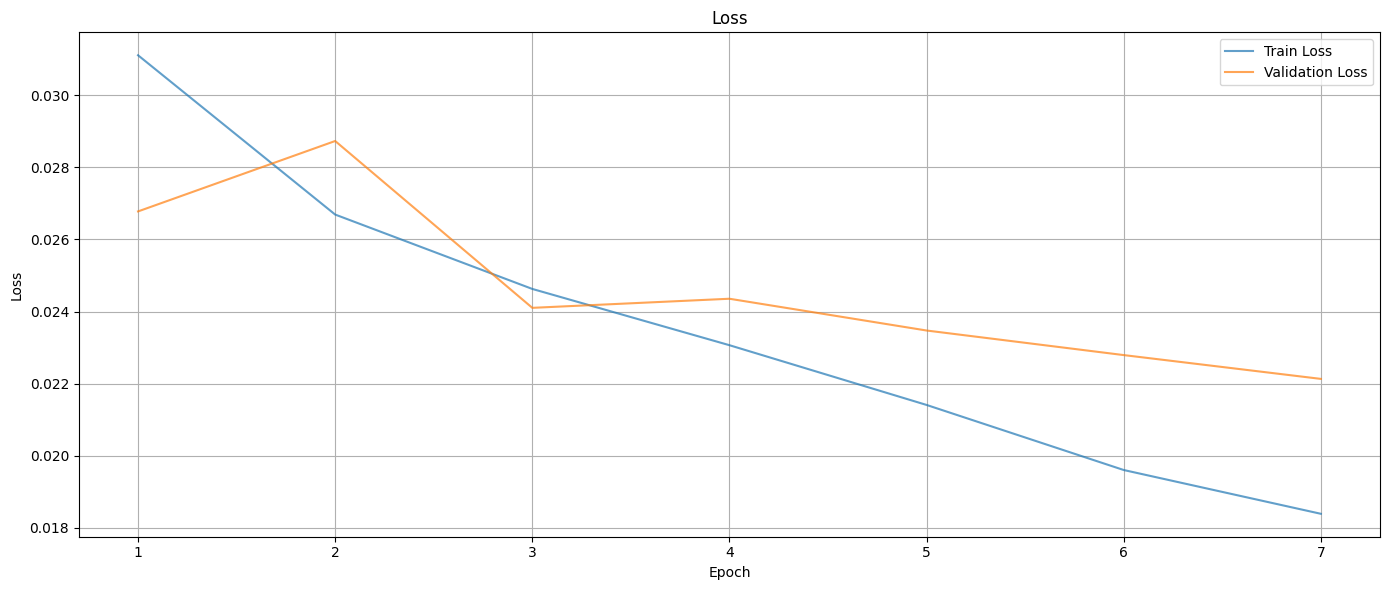

In [14]:
# Визуализация графиков
plot_losses(train_loss_by_epoch, val_loss_by_epoch)